In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import re
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.io as torchio


# Q1. PCA

In [2]:
# -- Q1. PCA --

# Load csv data to an np.array
with open("PADL-Q1.csv", "r") as f:
    reader = csv.reader(f)
    data_headers = next(reader)
    data = np.array(list(reader)).astype(float)

print("--- Data ---")
print(data_headers)
print(data[:5])

print("\n--- Variance ---")
data_var = np.var(data, axis=0)
print(sum(data_var))
print(data_var)


--- Data ---
['x1', 'x2', 'x3', 'x4', 'x5']
[[ 0.91890765  3.18388059 -0.08010414  9.3159354   5.2941181 ]
 [-2.46848262  1.69499138 -1.762808    7.91247192  2.4641442 ]
 [-0.86661073 -0.02815577  4.8980317  11.77602453 -4.4810839 ]
 [ 0.15403261  2.63287823 -2.36163801  3.26223239  4.0097756 ]
 [-0.62210432  5.51591972 -0.39977591 12.13958265  6.4871446 ]]

--- Variance ---
114.70494912140819
[ 2.048654    8.03910539 17.88568982 32.31447983 54.41702008]


## a. Apply PCA with n=5

--- data_pca5 Variance ---
114.70494912140809
[61.7643465  34.48928083 11.77245573  5.28311027  1.39575579]
[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]

--- Variance Proportions ---
First 1 dims variance proportion: 0.5384627862600507
First 2 dims variance proportion: 0.8391410141574704
First 3 dims variance proportion: 0.9417735144837427
First 4 dims variance proportion: 0.9878317735978975
First 5 dims variance proportion: 1.0


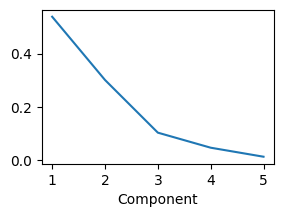

In [3]:
# Apply PCA with 5 components
pca5 = PCA(n_components=5)
data_pca5 = pca5.fit_transform(data)

# Calculate variance of PCA components
print("--- data_pca5 Variance ---")
data_pca5_var = np.var(data_pca5, axis=0)
data_pca5_var_sum = sum(data_pca5_var)
print(data_pca5_var_sum)
print(data_pca5_var)
print(data_pca5_var / data_pca5_var_sum)

# Calculate proportion of variances to sum of variances
print("\n--- Variance Proportions ---")
for i in range(1, 6):
    print(f"First {i} dims variance proportion: {sum(data_pca5_var[:i]) / data_pca5_var_sum}")

# Plot the variance proportions
plt.figure(figsize=(3, 2))
plt.plot(range(1, 6), data_pca5_var / data_pca5_var_sum)
plt.xlabel("Component")
plt.xticks(range(1, 6))
plt.show()


### Reasoning

Summing the proportion of variance held by the first N dimensions:  

- First 2 PCA dimensions hold 83.91% of the variance.  
- First 3 PCA dimensions hold 94.18% of the variance.  
- First 4 PCA dimensions hold 98.78% of the variance.  

This shows dimensions > 3 hold a relatively small percentage of the datasets information.  
Plotting the proportions also shows an inflectorchion point at 3 components.  

Therefore, I believe $D_{min}=3$.


## b. Repeat PCA with n=3

In [4]:
# Apply PCA with 3 components
pca3 = PCA(n_components=3)
data_pca3 = pca3.fit_transform(data)

# Calculate variance of PCA components
print("--- data_pca3 Variance ---")
data_pca3_var = np.var(data_pca3, axis=0)
data_pca3_var_sum = sum(data_pca3_var)
print(data_pca3_var_sum)
print(data_pca3_var)
print(data_pca3_var / data_pca3_var_sum)

# Calculate proportion of variances to sum of variances
print("\n--- Variance Proportions ---")
for i in range(1, 4):
    print(f"First {i} dim variances: {sum(data_pca3_var[:i]) / data_pca3_var_sum}")

print("\n--- PCA Components ---")
print(pca3.components_)

# Dirty code to generate latex equations for below markdown
print("\n--- PCA Latex Equations ---")
data_mean = np.mean(data, axis=0)
for i in range(3):
    output = f"\hat{{X}}_{i + 1} = "
    for j in range(5):
        if pca3.components_[i][j] > 0:
            if j > 0: output += " + "
            else: output += " "
        elif pca3.components_[i][j] < 0:
            if j > 0: output += " - "
            else: output += "-"
        output += f"{abs(pca3.components_[i][j]):.3f}(x_{{{j}}}-{data_mean[j]:.3f})"
    print(f"${output}$")


--- data_pca3 Variance ---
108.02608306274739
[61.7643465  34.48928083 11.77245573]
[0.57175401 0.31926809 0.1089779 ]

--- Variance Proportions ---
First 1 dim variances: 0.5717540130178995
First 2 dim variances: 0.8910220995304451
First 3 dim variances: 1.0

--- PCA Components ---
[[-0.09281879  0.02527186 -0.34876981  0.14508263 -0.92089992]
 [ 0.00562362 -0.29870463 -0.11422131 -0.94062257 -0.11369515]
 [ 0.11266752 -0.13315622  0.91420302 -0.02393429 -0.36501429]]

--- PCA Latex Equations ---
$\hat{X}_1 = -0.093(x_{0}-0.856) + 0.025(x_{1}-2.238) - 0.349(x_{2}-3.100) + 0.145(x_{3}-3.957) - 0.921(x_{4}-4.884)$
$\hat{X}_2 =  0.006(x_{0}-0.856) - 0.299(x_{1}-2.238) - 0.114(x_{2}-3.100) - 0.941(x_{3}-3.957) - 0.114(x_{4}-4.884)$
$\hat{X}_3 =  0.113(x_{0}-0.856) - 0.133(x_{1}-2.238) + 0.914(x_{2}-3.100) - 0.024(x_{3}-3.957) - 0.365(x_{4}-4.884)$


### Equations

First 3 components in decreasing order of variance.  
SKLearn calculates the PCA component matrices based on a de-meaned X.  

**Component 1**  
Var=61.764  
$\hat{X}_1 = -0.093(x_{0}-0.856) + 0.025(x_{1}-2.238) - 0.349(x_{2}-3.100) + 0.145(x_{3}-3.957) - 0.921(x_{4}-4.884)$  

**Component 2**  
Var=34.489  
$\hat{X}_2 =  0.006(x_{0}-0.856) - 0.299(x_{1}-2.238) - 0.114(x_{2}-3.100) - 0.941(x_{3}-3.957) - 0.114(x_{4}-4.884)$  

**Component 3**  
Var=11.772  
$\hat{X}_3 =  0.113(x_{0}-0.856) - 0.133(x_{1}-2.238) + 0.914(x_{2}-3.100) - 0.024(x_{3}-3.957) - 0.365(x_{4}-4.884)$  


# Q2. Regression

(80, 5)


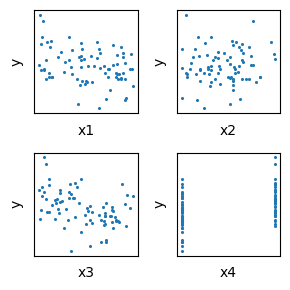

In [5]:
# -- Q2. Regression --

# Suppress ill-conditioned warning
import warnings
warnings.filterwarnings("ignore")

# Load csv data to an np.array
with open("PADL-Q2-train.csv", "r") as f:
    reader = csv.reader(f)
    data = np.array(list(reader)[1:]).astype(float)
    all_X = data[:, :-1]
    all_y = data[:, -1]

# Plot each variable against y in 2x2 grid
print(data.shape)
plt.figure(figsize=(3, 3))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(all_X[:, i], all_y, s=1.5)
    plt.xlabel(f"x{i + 1}")
    plt.ylabel("y")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


In [6]:
# Represents all possible different regression setups
# This is so I can programmatically try all combinations
class Model:
    def __init__(self, poly_degree, to_normalize, model):
        self.poly_degree = poly_degree
        self.to_normalize = to_normalize
        self.model = model

        if poly_degree > 1:
            self.poly = PolynomialFeatures(degree=poly_degree)
        
        # Calculate name for the printing the model
        self.name = "Model("
        self.name += f"degree={self.poly_degree}"
        self.name += f", normalize={self.to_normalize}"
        self.name += f", model={self.model.__class__.__name__}"
        if self.model.__class__.__name__ == "Ridge":
            self.name += f", alpha={self.model.alpha}"
        self.name += ")"
    
    def fit(self, X, y):
        # Apply polynomial features if needed
        if self.poly_degree > 1:
            X = self.poly.fit_transform(X)
    
        # Normalize data to have mean 0 and std 1 if needed
        if self.to_normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            std[std == 0] = 1
            X = (X - mean) / std
        
        self.model.fit(X, y)
    
    def predict(self, X):
        # Apply polynomial features if needed
        if self.poly_degree > 1:
            X = self.poly.transform(X)
        
        # Normalize data to have mean 0 and std 1 if needed
        if self.to_normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            std[std == 0] = 1
            X = (X - mean) / std

        return self.model.predict(X)

# Represents multiple models combined together
class PiecewiseModel:
    def __init__(self, boundary_masker, models):
        self.boundary_masker = boundary_masker
        self.models = models
        self.name = "PiecewiseModel(["
        self.name += ",".join([model.name for model in self.models])
        self.name += "])"

    def fit(self, X, y):
        # Fit each model with the corresponding masked data
        for i, model in enumerate(self.models):
            mask = self.boundary_masker(X, i)
            model.fit(X[mask], y[mask])

    def predict(self, X):
        # Predict using each model with their corresponding masked data
        y = np.zeros(X.shape[0])
        for i, model in enumerate(self.models):
            mask = self.boundary_masker(X, i)
            y[mask] = model.predict(X[mask])
        return y


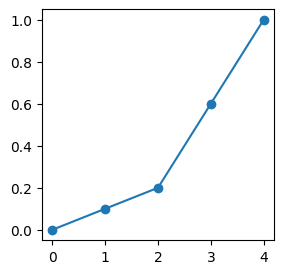

In [7]:
# Sanity check piecewise works
def boundary_masker(X, i):
    if i == 0:
        return X[:, 0] < 2
    else:
        return X[:, 0] >= 2

piecewise_x = np.array([[0], [1], [2], [3], [4]])
piecewise_y = np.array([0, 0.1, 0.2, 0.6, 1])

piecewise = PiecewiseModel(boundary_masker, [Model(1, False, LinearRegression()), Model(1, False, LinearRegression())])
piecewise.fit(piecewise_x, piecewise_y)

plt.figure(figsize=(3, 3))
plt.scatter(piecewise_x, piecewise_y)
plt.plot(piecewise_x, piecewise.predict(piecewise_x))
plt.show()


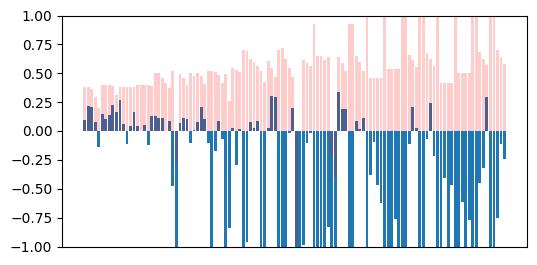

--- Results ---
Best model: Model(degree=4, normalize=True, model=Ridge, alpha=0.1)
Best model, mean R2 KFold=5: 0.33428997746725964
Best model, R2 over all data: 0.6380187792688217


In [8]:
def boundary_masker(X, i):
    # Piecewise based on column 4 (w)
    if i == 0:
        return X[:, 3] < 0.05
    else:
        return X[:, 3] >= 0.05

# Setup all the models to evaluate
models = []
for poly_degree in range(1, 7):
    for to_normalize in [False, True]:
        for to_piecewise in [False, True]:

            # Piecewise 2 linear regressions
            if to_piecewise:
                models.append(PiecewiseModel(boundary_masker, [
                    Model(poly_degree, to_normalize, LinearRegression()),
                    Model(poly_degree, to_normalize, LinearRegression())
                ]))

            # Single linear regression
            else:
                models.append(Model(poly_degree, to_normalize, LinearRegression()))

            for alpha in [0.0, 0.1, 1.0, 10.0]:
                # Piecewise 2 ridge regressions
                if to_piecewise:
                    models.append(PiecewiseModel(boundary_masker, [
                        Model(poly_degree, to_normalize, Ridge(alpha=alpha)),
                        Model(poly_degree, to_normalize, Ridge(alpha=alpha))
                    ]))

                # Single ridge regression
                else:
                    models.append(Model(poly_degree, to_normalize, Ridge(alpha=alpha)))

# Calculate mean R2 score of each model across 5 KFold splits
np.random.seed(1)
kf = KFold(n_splits=5, shuffle=True)

models_r2_kfmean = []
models_r2_all = []
for model in models:
    r2s = []
    for train_idx, test_idx in kf.split(all_X):
        model.fit(all_X[train_idx], all_y[train_idx])
        pred_test_y = model.predict(all_X[test_idx])
        r2s.append(r2_score(all_y[test_idx], pred_test_y))
    models_r2_kfmean.append(np.mean(r2s))

    model.fit(all_X, all_y)
    pred_all_y = model.predict(all_X)
    models_r2_all.append(r2_score(all_y, pred_all_y))

# Plot mean R2 / all data R2 to see overall performance
plt.figure(figsize=(6, 3))
plt.bar(range(len(models_r2_kfmean)), models_r2_kfmean)
plt.bar(range(len(models_r2_all)), models_r2_all, alpha=0.2, color="red")
plt.xticks([])
plt.ylim(-1, 1)
plt.show()

print("--- Results ---")
best_idx = np.argmax(models_r2_kfmean)
best_model = models[best_idx]
best_r2_mean = models_r2_kfmean[best_idx]
best_r2_all = models_r2_all[best_idx]
print(f"Best model: {best_model.name}")
print(f"Best model, mean R2 KFold=5: {best_r2_mean}")
print(f"Best model, R2 over all data: {best_r2_all}")

# Train best model against full data again
best_model.fit(all_X, all_y)


### Results Reasoning

**Overview**

I produce a set of models varying the following:  

- Data polynomial basis **(1 - 6)**
- Data normalization **(yes / no)**
- Whether to use piecewise regression **(yes / no)**  
- Regression model **(linear / ridge)**
  - For ridge regression, alpha value **(0.1, 1, 10)**  

**Piecewise**

For piecewise regression I use 2 of the same model, split on some boundary.  
From inspection of the data, column `w` is binary between 2 values.  
Due to complexity constraints I only tested a piecewise regression with 1 boundary on `w` in these 2 classes.  

**Overfitting**

For training, I need to consider overfitting due to only having 80 values, as I want a generalised model.  
If my number of parameters > number of data points the regressor might "remember" the values.  
To prevent this, I use  k-fold data splitting:  

- Split data into $k$ groups
- Leave 1 group out and fit model on the rest
- Use the 1 group for prediction and R2 score

I can then average the R2 score over the folds and use that as the main metric.  

**Random Results**

An issue here arises due to the result being different every time its ran if k-fold is set to shuffle.  
Evidently the results are highly dependant on how the random groups are assigned.  

Generally however, it seems a **single (non-piecewise) ridge regression** works the best.  
The degree of polynomial basis, whether to normalize, and the alpha, changes per run.

In [9]:
# Predict best model against PADL-Q2-unseen.csv
with open("PADL-Q2-unseen.csv", "r") as f:
    reader = csv.reader(f)
    data = np.array(list(reader)[1:]).astype(float)
test_X = data[:, :-1]
test_y = data[:, -1]
pred_y = best_model.predict(test_X)
r2 = r2_score(test_y, pred_y)
print(f"Test R2: {r2}")


Test R2: 0.6380187792688217


# Q3. Embeddings

In [10]:
# -- Q3. Embeddings --

# Read pg48320.txt
with open("pg48320.txt", "r", encoding="utf-8") as f:
    text = f.read()


## a. Extract Words

**1. Clean the text.**  

- Replace all punctuation, apart from hyphens and newlines, with spaces.  
- Convert the text to lowercase.  

**2. Extract Words.**  

- Find words by splitting on all spaces.

**3. Extract Triplets.**

- Loop over words, compare to "the", and adding the previous / current / next to a list.

In [11]:
# Preprocess text
clean_text = re.sub(r"[^a-zA-Z \-]", " ", text).lower()

# Split text into non-empty words
words = clean_text.split(" ")

# Extract triplets where middle word is "the"
triplets = set()
for i in range(1, len(words) - 1):
    if words[i] == "the":
        triplets.add((words[i - 1], words[i], words[i + 1]))

print(f"Found {len(text)} characters, {len(words)} words, {len(triplets)} triplets.")


Found 595374 characters, 139178 words, 4360 triplets.


## b. Find Matching Triplets

We just need to loop over each triplet for each keyword and perform the suitability check.  

- Check the relevant word has 3+ characters, and then check the suffix matches.  

**Note:** This would be improved by checking the word is different from the keyword.  

In [12]:
# For each keyword
keywords = ["gold", "diamond", "robbery", "bank", "police"]
keyword_triplets = []
for keyword in keywords:

    # For each triplet
    matching_triplets = []
    for triplet in triplets:
        word = triplet[2]
        
        # Check suffixes match atleast 3 characters
        if len(word) >= 3 and keyword[-3:] == word[-3:]:
            matching_triplets.append(triplet)
    
    # Found all matching triplets
    keyword_triplets.append(matching_triplets)
    print(f"Keyword {keyword} has {len(matching_triplets)} matching triplets")
    print(matching_triplets)
    print("")


Keyword gold has 21 matching triplets
[('do', 'the', 'old'), ('of', 'the', 'old'), ('of', 'the', 'gold'), ('into', 'the', 'manifold'), ('screamed', 'the', 'old'), ('crossed', 'the', 'threshold'), ('by', 'the', 'old'), ('with', 'the', 'gold'), ('said', 'the', 'old'), ('as', 'the', 'old'), ('from', 'the', 'old'), ('and', 'the', 'two-hundred-year-old'), ('over', 'the', 'threshold'), ('rack', 'the', 'old'), ('remember', 'the', 'old'), ('in', 'the', 'old'), ('in', 'the', 'household'), ('one', 'the', 'old'), ('', 'the', 'old'), ('in', 'the', 'cold'), ('to', 'the', 'old')]

Keyword diamond has 11 matching triplets
[('in', 'the', 'second'), ('armitage', 'the', 'second'), ('if', 'the', 'second'), ('at', 'the', 'second'), ('observe', 'the', 'second'), ('snap', 'the', 'bond'), ('upon', 'the', 'second'), ('', 'the', 'second'), ('to', 'the', 'second'), ('solder', 'the', 'second'), ('of', 'the', 'second')]

Keyword robbery has 32 matching triplets
[('be', 'the', 'very'), ('to', 'the', 'very'), ('are

## c. Find Semantically Good Triplets

I train a model on the list of words from earlier.  
Then using this, sort the triplets for each word by the semantic similarity between word 1 and 3.  

In [14]:
# Train word2vec over all words
model = Word2Vec([ words ], vector_size=300, window=5, min_count=1, workers=4)

# For each keyword and associated triplets
keyword_triplets_best = []
for i in range(len(keyword_triplets)):
    print(f"Finding top 5 triplets for keyword '{keywords[i]}'")

    # Sort triplets by similarity of word 1 and word 3
    scored_triplets = [ (t, model.wv.similarity(t[0], t[2])) for t in keyword_triplets[i] ]
    scored_triplets = sorted(scored_triplets, key=lambda x: x[1], reverse=True)
    scored_triplets = scored_triplets[:5]

    # Found top 5 triplets
    keyword_triplets_best.append(scored_triplets)
    for triplet, score in scored_triplets:
        print(f"- ({triplet[0]} {triplet[1]} {triplet[2]}) score={score:.3f}")
    print("")


Finding top 5 triplets for keyword 'gold'
- (from the old) score=0.998
- (one the old) score=0.998
- (by the old) score=0.998
- (in the old) score=0.998
- (as the old) score=0.998

Finding top 5 triplets for keyword 'diamond'
- (if the second) score=0.897
- (at the second) score=0.896
- (in the second) score=0.896
- (to the second) score=0.896
- (of the second) score=0.896

Finding top 5 triplets for keyword 'robbery'
- (is the very) score=1.000
- (to the very) score=1.000
- (was the very) score=1.000
- (of the very) score=1.000
- (that the very) score=1.000

Finding top 5 triplets for keyword 'bank'
- (upon the mud-bank) score=0.009
- (was the clank) score=0.001
- (expect the bank) score=-0.010
- (leaves the bank) score=-0.029
- (from the bank) score=-0.125

Finding top 5 triplets for keyword 'police'
- (from the office) score=0.998
- (in the office) score=0.998
- (into the office) score=0.998
- (at the office) score=0.998
- (of the office) score=0.998



# Q4. Basic MLP

I have limited training data to the range (0, 10).  
The test data is limited to the external range (10, 20).  
Furthermore, the larger the range of values used the longer the network takes to train.  

Simple networks with only linear and ReLU layers have difficulty with generalizing for multiplication.  
Something such as a Recurrent NN may be more suited.  

In [15]:
# -- Q4. Basic MLP --

# Define basic MLP
class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Generate random data in range (0, 10)
train_X = np.random.rand(1000, 2) * 10
train_y = train_X[:, 0] * train_X[:, 1]
train_X = torch.tensor(train_X).float()
train_y = torch.tensor(train_y).float().reshape(-1, 1)

# Generate test data outside the range (10, 20)
test_X = 10 + np.random.rand(1000, 2) * 10
test_y = test_X[:, 0] * test_X[:, 1]
test_X = torch.tensor(test_X).float()
test_y = torch.tensor(test_y).float().reshape(-1, 1)


In [16]:
# Training loop for basic MLP
model = BasicMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

max_epoch = 1000
print(f"Training for {max_epoch} epochs...")
for epoch in range(max_epoch):
    optimizer.zero_grad()
    train_y_pred = model(train_X)
    loss = criterion(train_y_pred, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{max_epoch}], loss {loss.item()}")
print("Training done.")


Training for 1000 epochs...
Epoch [0/1000], loss 1160.2225341796875
Epoch [50/1000], loss 129.7347869873047
Epoch [100/1000], loss 14.285234451293945
Epoch [150/1000], loss 6.39487886428833
Epoch [200/1000], loss 4.322103977203369
Epoch [250/1000], loss 3.2506775856018066
Epoch [300/1000], loss 2.546607255935669
Epoch [350/1000], loss 2.0758602619171143
Epoch [400/1000], loss 1.7134166955947876
Epoch [450/1000], loss 1.4140819311141968
Epoch [500/1000], loss 1.1759065389633179
Epoch [550/1000], loss 0.9909968376159668
Epoch [600/1000], loss 0.8400720357894897
Epoch [650/1000], loss 0.6973899006843567
Epoch [700/1000], loss 0.5768535137176514
Epoch [750/1000], loss 0.4763795733451843
Epoch [800/1000], loss 0.39716723561286926
Epoch [850/1000], loss 0.3330005407333374
Epoch [900/1000], loss 0.3565601110458374
Epoch [950/1000], loss 0.24368982017040253
Training done.


In [17]:
print("Evaluating model:")

# Evaluate against a random sample of 5 from training data
indices = np.random.choice(train_X.shape[0], 5, replace=False)
sample_X = train_X[indices]
sample_y = train_y[indices]
sample_y_pred = model(sample_X)
sample_loss = torch.abs(sample_y_pred - sample_y).mean()
print(f"Sample loss: {sample_loss.item()}")

# Evaluate against all of the test data
test_y_pred = model(test_X)
test_loss = torch.abs(test_y_pred - test_y).mean()
print(f"Test loss: {test_loss.item()}")


Evaluating model:
Sample loss: 0.2473130226135254
Test loss: 56.01510238647461


# Q5. Telling the Time

## Justification

For clock face recognition I have chosen to use a Convolutional Neural Network, trained as a classifier.  
That is, it takes in a tensor representing an image, and outputs probabilities of 720 classes representing each possible minute.  

The use of convolution is intended to allow the network to learn specific features (e.g. clock hands, edges). 
 
The choice of using classification is to constrain the output of the network to just the outputs we want.  
A regression problem would produce decimal values, which means the network would have to do more work than necessary.  
With the more defined goal of classification I can then use softmax with cross entropy loss.  

Due to training the model as classification, and the problem definition requiring hours:minutes, I need a set of processing functions.  
I define label_to_onehot() and onehot_to_label() to convert between (hours, minutes) and one-hot of length (720) representations.  

For training, I use onehot representation so I can use cross entropy as described above for the loss function.  
For validation, I use the pair representation with the described median algorithm.  
To implement the described median algorithm I convert the (hours, minutes) to a flat minutes through the day, then calculate the absolute difference.  
I then also find the min of this value with `12*60 - diff` to allow for the circular nature of time.  

Looking at the final graphs of training and validation loss

## Extracting Data

In [2]:
# -- Q5. Telling the Time --

def preprocess_image(image):
    # Input image is (3x448x448) in float range [0..1]
    # Resize to (3x224x224) with interpolation
    image = nn.functional.interpolate(image.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)
    # Greyscale to (1x224x224) with mean
    image = image.mean(dim=0, keepdim=False).unsqueeze(0)
    return image

def label_to_onehot(label):
    # Input label is (Bx2) in range [0..12, 0..59]
    # Convert to onehot (Bx720)
    onehot = torch.zeros(label.shape[0], 720)
    onehot[:, label[:, 0] * 60 + label[:, 1]] = 1
    return onehot

def onehot_to_label(onehot):
    # Input onehot is (Bx720)
    # Convert to label (Bx2)
    label = torch.argmax(onehot, dim=1)
    return torch.stack([label // 60, label % 60], dim=1)

# Images stored in clocks_dataset/train/0000.png - 9999.png as (448x448) RGB images
# Labels stored in clocks_dataset/train/0000.txt - 9999.txt as "HH:MM" strings
# Output N images tensors size (3x448x448) in float range [0..1]
# Output N labels tensors size (720) as one-hot encoding of [H, M]
class ClockDataset(torch.utils.data.Dataset):
    def __init__(self):
        # Load all images and labels from files
        self.images = []
        self.labels = []
        to_load = 10000
        for i in range(to_load):
            # Read from PNG to (3x448x448) tensor in range [0, 1], then preprocess
            image = torchio.read_image(f"clocks_dataset/train/{i:04d}.png") / 255
            image = preprocess_image(image)
            self.images.append(image)

            # Read from "HH:MM" string to (2) tensor as [H, M], then convert to onehot (720)
            label = open(f"clocks_dataset/train/{i:04d}.txt", "r").read().strip() 
            label = torch.tensor([int(x) for x in label.split(":")], dtype=torch.int)
            label = label_to_onehot(label.unsqueeze(0)).squeeze(0)
            self.labels.append(label)

            if (i + 1) % 200 == 0:
                progress_bar = "=" * ((i + 1) // 200) + " " * ((to_load - i - 1) // 200)
                print(f"\rLoading images [{progress_bar}] {i + 1}/{to_load}", end="")

        print("")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


Loading images [==================================================] 10000/10000

Loaded Clock Dataset

- Training Size: 8500
- Validation Size: 1500
- Training Batch Size: 100
- Training Batches: 85
- Training Batch Image Shape: torch.Size([1, 224, 224])
- Training Batch Label Shape: torch.Size([720])


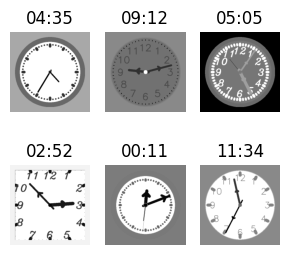

In [3]:
# Load dataset, split into train / validate, create dataloaders
clock_dataset = ClockDataset()
train_size = int(0.85 * len(clock_dataset))
validation_size = len(clock_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(clock_dataset, [train_size, validation_size])
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Print overview of dataset
print("\nLoaded Clock Dataset\n")
print(f"- Training Size: {len(train_dataset)}")
print(f"- Validation Size: {len(validation_dataset)}")
print(f"- Training Batch Size: {batch_size}")
print(f"- Training Batches: {len(train_loader)}")
image, label = train_dataset[0]
print(f"- Training Batch Image Shape: {image.shape}")
print(f"- Training Batch Label Shape: {label.shape}")

# Visualise the first 6 images and labels
plt.figure(figsize=(3, 3))
for i in range(6):
    image, label = train_dataset[i]
    plt.subplot(2, 3, i + 1)
    image = image.squeeze(0).numpy()
    label = onehot_to_label(label.unsqueeze(0)).squeeze(0)
    plt.imshow(image, cmap="gray")
    plt.title(f"{int(label[0]):02d}:{int(label[1]):02d}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Model and Training

In [11]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CNN for clock face classification
# Output is 12 * 60 (720) classes for each minute of the day
class ClockClassificationCNN(nn.Module):
    def __init__(self):
        super(ClockClassificationCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(48 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 12 * 60)
        )

    def forward(self, x):
        return self.net(x)

def criterion_eval(pred_y, real_y):
    # Input tensor shape: (B x 2)
    # Convert (hours, minutes) to minutes, calc diff wrapped around 12 hours
    pred_mins = pred_y[:, 0] * 60 + pred_y[:, 1]
    real_mins = real_y[:, 0] * 60 + real_y[:, 1]
    diff = torch.abs(pred_mins - real_mins)
    diff = torch.min(diff, 12 * 60 - diff)
    return torch.median(diff)

def criterion_train(pred_y, real_y):
    # Input tensor shape: (B x 720)
    # Softmax cross entropy loss for onehot labels
    return nn.CrossEntropyLoss()(pred_y, real_y)


Using device: cuda


In [34]:
# Load new model and optimizer
model = ClockClassificationCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
# Training loop for clock classification
model.to(device)
model.train()
max_epoch = 50
max_training_batch = len(train_loader)
epoch_train_losses = []
epoch_validation_losses = []
epoch_validation_accuracies = []
print(f"Training for {max_epoch} epochs with {max_training_batch} training batches...")
for epoch in range(max_epoch):

    # Train against training dataset
    batch_epoch_train_losses = []
    for i, (images, real_y) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        real_y = real_y.to(device)
        pred_y = model(images)
        loss = criterion_train(pred_y, real_y)
        loss.backward()
        optimizer.step()
        batch_epoch_train_losses.append(loss.item())
        if (i + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{max_epoch}], batch [{(i + 1)}/{max_training_batch}], training loss {(loss.item()):.3f}", end="\r")
    epoch_training_loss = np.mean(batch_epoch_train_losses)
    epoch_train_losses.append(epoch_training_loss)

    # Accumulate results against validation dataset and calculate loss
    model.eval()
    with torch.no_grad():
        all_real_y = []
        all_pred_y = []
        for images, real_y in validation_loader:
            images = images.to(device)
            pred_y = model(images).cpu()
            all_real_y.append(onehot_to_label(real_y))
            all_pred_y.append(onehot_to_label(pred_y))
        epoch_validation_loss = criterion_eval(torch.cat(all_pred_y), torch.cat(all_real_y)).item()
        accuracy_correct = (torch.cat(all_real_y) == torch.cat(all_pred_y)).all(dim=1).sum().item()
        accuracy_total = len(torch.cat(all_real_y))
        epoch_validation_accuracy = accuracy_correct / accuracy_total
        epoch_validation_losses.append(epoch_validation_loss)
        epoch_validation_accuracies.append(epoch_validation_accuracy)
    model.train()

    # Calculate mean loss for epoch and output
    print(f"Epoch [{epoch+1}/{max_epoch}], training loss {(epoch_training_loss):.3f}, validation loss {(epoch_validation_loss):.3f}, validation accuracy {(epoch_validation_accuracy):.3f}")

print("Training finished.")


Training for 50 epochs with 85 training batches...
Epoch [1/50], training loss 6.581, validation loss 184.000, validation accuracy 0.001
Epoch [2/50], training loss 6.574, validation loss 176.000, validation accuracy 0.001
Epoch [3/50], training loss 6.561, validation loss 166.000, validation accuracy 0.004
Epoch [4/50], training loss 6.182, validation loss 61.000, validation accuracy 0.091
Epoch [5/50], training loss 3.397, validation loss 1.000, validation accuracy 0.325
Epoch [6/50], training loss 1.866, validation loss 1.000, validation accuracy 0.441
Epoch [7/50], training loss 1.329, validation loss 1.000, validation accuracy 0.493
Epoch [8/50], training loss 0.981, validation loss 0.000, validation accuracy 0.515
Epoch [9/50], training loss 0.788, validation loss 0.000, validation accuracy 0.541
Epoch [10/50], training loss 0.614, validation loss 0.000, validation accuracy 0.545
Epoch [11/50], training loss 0.492, validation loss 0.000, validation accuracy 0.543
Epoch [12/50], t

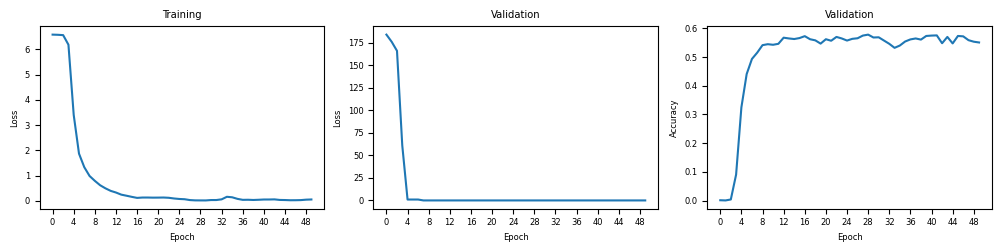

In [36]:
# Plot training and validation losses on adjacent graphs
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))

ax[0].plot(epoch_train_losses)
ax[0].set_title("Training")
ax[0].set_xticks(range(0, max_epoch, 4))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(epoch_validation_losses)
ax[1].set_title("Validation")
ax[1].set_xticks(range(0, max_epoch, 4))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

# Plot validation accuracy
ax[2].plot(epoch_validation_accuracies)
ax[2].set_title("Validation")
ax[2].set_xticks(range(0, max_epoch, 4))
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


Final Validation Loss: 0
Final Validation Accuracy: 0.551


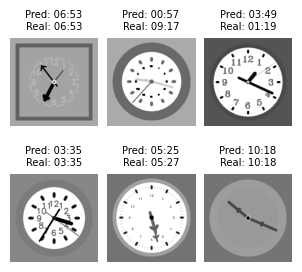

In [37]:
# Final evaluation of model against full validation set
model.to(device)
model.eval()
with torch.no_grad():
    all_real_y = []
    all_pred_y = []
    for images, real_y in validation_loader:
        images = images.to(device)
        pred_y = model(images).cpu()
        all_real_y.append(onehot_to_label(real_y))
        all_pred_y.append(onehot_to_label(pred_y))
    final_validation_loss = criterion_eval(torch.cat(all_pred_y), torch.cat(all_real_y)).item()
    correct = (torch.cat(all_real_y) == torch.cat(all_pred_y)).all(dim=1).sum().item()
    total = len(torch.cat(all_real_y))
    accuracy = correct / total

print(f"Final Validation Loss: {final_validation_loss}")
print(f"Final Validation Accuracy: {accuracy:.3f}")

# Visualise the first 6 images, show predicted vs real labels
plt.figure(figsize=(3, 3))
plt.rc("font", size=6)
for i in range(6):
    image, real_y = validation_dataset[i]
    image = image.to(device)
    pred_y = onehot_to_label(model(image.unsqueeze(0))).cpu().numpy()
    real_y = onehot_to_label(real_y.unsqueeze(0)).cpu().numpy()
    image = image.squeeze(0).squeeze(0).cpu().numpy()
    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Pred: {int(pred_y[0,0]):02d}:{int(pred_y[0,1]):02d}\nReal: {int(real_y[0,0]):02d}:{int(real_y[0,1]):02d}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Utility

In [38]:
# Save weights to file
torch.save(model.state_dict(), "clock_model.pt")


In [8]:
# Load model from file
model = ClockClassificationCNN()
model.load_state_dict(torch.load("clock_model.pt"))


<All keys matched successfully>

# Q6. Generative

In [ ]:
# -- Q6. Generative Model --